# Chaîne de traitement _data science_.
## _Data wrangling_ avec `python`

Dans cet exercice on va essayer de créer un dataset et de normaliser les données pour les utiliser plus tard dans un autre workshop 

Le _dataset_ présente des données immobilières californiennes. Il compte des variables telles que la population, le salaire médian, le prix moyen d'un logement, _etc_. Et ce pour chaque _block group_ (le _block group_ est la la plus petite division administrative aux Etats-Unis - entre 500 et 5000 personnes).

### Objectifs

On cherche à mettre au point un modèle de prédiction du prix médian d'un logement en fonction des autres informations. 

### Mesure de performance

On s'intéressera à terme à la minimisation de la RMSE Root Mean Square Error et/ou de à la MAE Mean Absolute Error de notre modèle :

$$
\newcommand\x{\mathbf{x}}
\newcommand\X{\mathbf{X}}
\newcommand\y{\mathbf{y}}
\newcommand\Y{\mathbf{Y}}
\newcommand\RMSE{\mbox{RMSE}}
\newcommand\MAE{\mbox{MAE}}
$$
$$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$$

$$
\MAE(\X,h)=\frac{\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}}{m}
$$

$h$ étant la fonction de prédiction du modèle.


### Préparation de l'environnement

Imports nécessaire pour les autres exercices

In [0]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# ignorer les warnings inutiles 
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Import des données

implémentation de la fonction qui se charge de :
* télécharger l'archive
* extraire les fichiers


In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    filepath = HOUSING_PATH + '/housing.tgz'
    urllib.request.urlretrieve(HOUSING_URL, filepath)
    untar_file(filepath)

def untar_file(file):
    tf = tarfile.open(file)
    tf.extractall(path=HOUSING_PATH)

On peut maintenant importer les données :

In [0]:
fetch_housing_data()

### Chargement des données en mémoire

De même, on va créer une fonction utilisant "pandas" qui charge les données en mémoire dans un Pandas Dataframe

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [0]:
housing = load_housing_data()

### Coup d'oeil

1. On observe les première lignes avec head()

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


2. Utilisons maintenant info() pour obtenir une description du jeu de données :

In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


3. La fonction `valuecounts()` permet de connaître, par exemple, le nombre de valeurs différentes d'une comme `ocean_proximity`, qui semble être catégorielle:

In [17]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

4. La méthode `describe()` permet enfin d'obtenir un résumé statistique des valeurs numériques :

In [18]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


5. On peut utiliser la fonction `hist()` pour afficher un histogramme par attribut numérique.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5cbe3e550>,
      dtype=object)

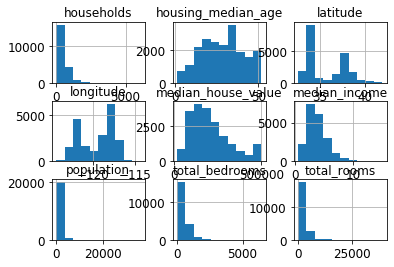

In [19]:
housing.hist()

### Création d'un jeu de test

#### Jeu de test aléatoire
Nous allons maintenant essayer de créer un Set de données aléatoires pour éviter l'overfit de notre algorithme


Créer un jeu de test est simple : on met aléatoirement 20% des données de côtés.

In [0]:
import numpy as np

# création de la méthode train_test_split de scikitlearn
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [21]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


#### Utilisation d'une fonction de hachage

Ci-dessous, on définit une fonction `split_train_test_by_id` construisant un jeu de test en hachant un identifiant unique à chaque ligne. Le résultat de ce _hash_ est mappé sur l'ensemble booléen $\{0,1\}$ en respectant le ratio afin de décider la destination de l'enregistrement (test ou entraînement).

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### Utilisation de `scikit-learn`
On utilise maintenant la vraie fonction `train_test_split` qui est mise en place dans scikit-learn

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
test_set, train_set = train_test_split(housing, test_size=0.2, random_state=42)

In [25]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


Pour ne pas introduire de biais statistique et respecter la règle du stratified sampling on va esseyer d'avoir une distribution représentative du `median_income`. Pour éviter les biais de sous-représentation ou sur-représentation, on essaye d'avoir un nombre limité de strates 

#### Echantillonage stratifié

 Nous désirons effectuer un échantillonage où les jeux d'entraînement et de test respectent les proportions de représentation des différentes catégories de salaire. Pour celà, nous commençons par créer une variable `income_cat`, pendant catégoriel de la variable numérique `median_income`

In [0]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

On peut observer les effectifs de chaque catégories.

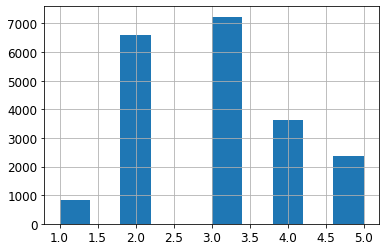

In [27]:
housing["income_cat"].hist()

On peut maintenant utiliser `StratifiedShuffleSplit` pour échantillonner le jeu de données en respectant notre contrainte :

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

[17606 18632 14650 ... 13908 11159 15775] [ 5241 10970 20351 ...  4019 12107  2398]


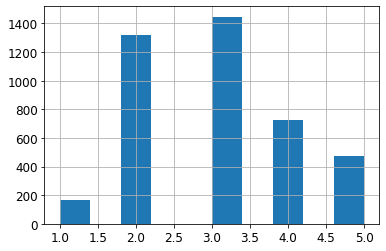

In [29]:
strat_test_set["income_cat"].hist()

Notre échantillonnage respecte bien les proportions du jeu initial. On n'a plus besoin de la colonne `income_cat` : on la supprime avec `drop()`.

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_ = set_.drop(columns=['income_cat'], inplace=True)

In [31]:
strat_train_set


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


### Explorer le jeu de données

Notre jeu de test étant constitué, nous pouvons commencer l'exploration. Nous allons travailler sur une copie du jeu d'entraînement pour éviter toute mauvaise surprise.

In [0]:
housing = strat_train_set.copy()

#### Visualisation de données géographiques

La bibliothèque matplotlib permet de gérer des données et les représenter graphiquement

Les coordonnées géographiques de nos enregistrements étant connues, on a envie de les représenter sur le plan :

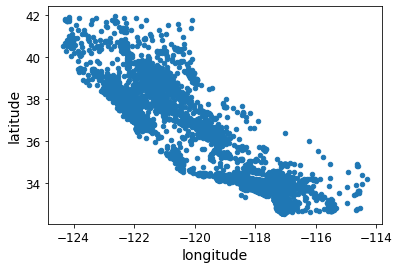

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude")

on va jouer sur la transparence des points pour mettre en évidence les densité de point :

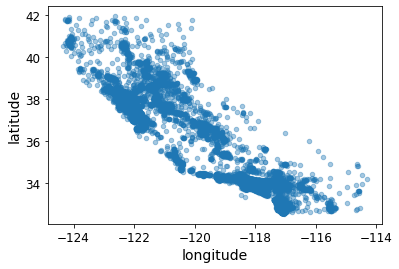

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)

On peut faire varier à loisir la taille de nos marqueurs (option `s`) et leur couleur (option `c` : on utilise une palette `cmap` prédéfinie nommée `jet`). Ici on veut distinguer les zones en fonction de leur population et de leur revenu moyen. 

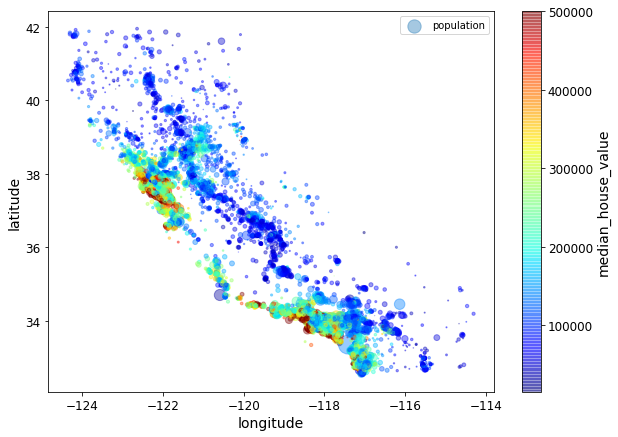

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

On constate que la situation géographique importe. On peut imaginer que la valeur moyenne d'une maison est corrélée à la proximité à l'océan.

une autre palette comme `cubehelix` aurait eu un rendu moins facile à interpréter. 

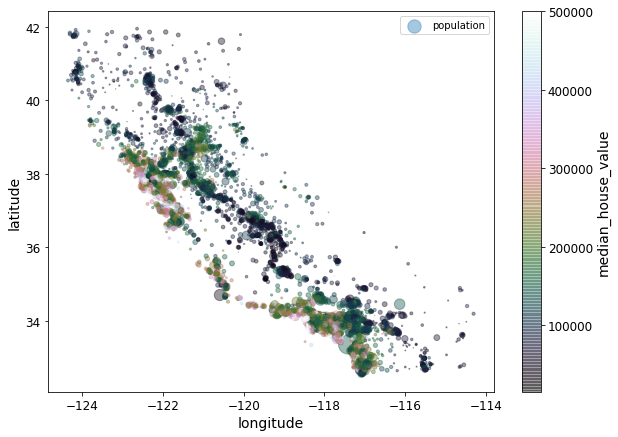

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("cubehelix"), colorbar=True,
    sharex=False)
plt.legend()

#### Recherche de corrélation

Les variables d'un jeu de données peuvent être liées deux à deux (plus ou moins fortement, positivement ou négativement), on doit donc calculer leur `corrélation`.

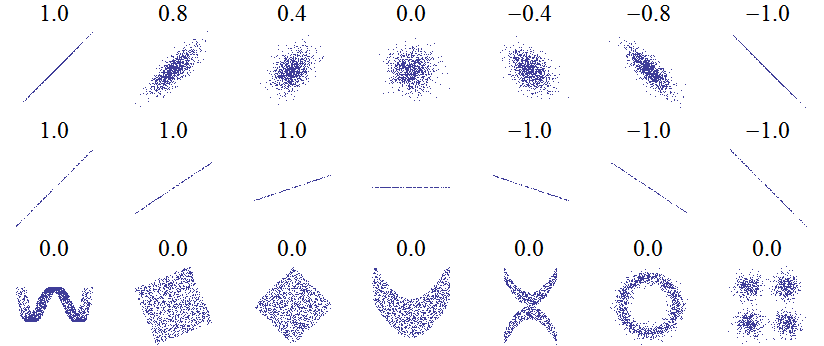

In [38]:
#Ici on display les matrices de corrélations connues graphiquement
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png")

Pour un jeu de données de petite taille tel que le notre, on peut calculer la matrice de corrélation avec `corr()`et en afficher une série, on va donc afficher celle de la variable `median_income` :

In [39]:
housing.corr().loc[['median_income']]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
median_income,-0.019583,-0.075205,-0.11136,0.200087,-0.00974,0.00238,0.010781,1.0,0.68716


`scatter_matrix` permet de visualiser les relations entre variables ainsi qu'un histogramme pour chaque variable sur la diagonale :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5ba5ad9b0>,
      dtype=object)

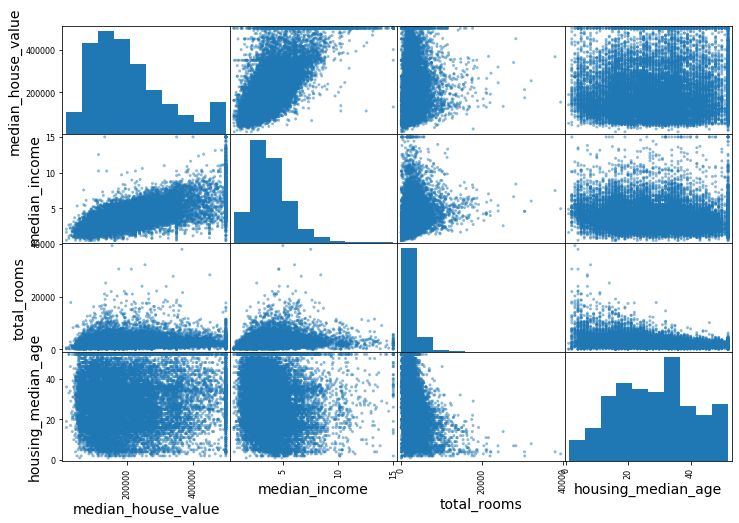

In [41]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


On remarque une corrélation positive forte entre `median_income` et `median_house_value`. 

Zoomons sur le deuxième nuage de point :

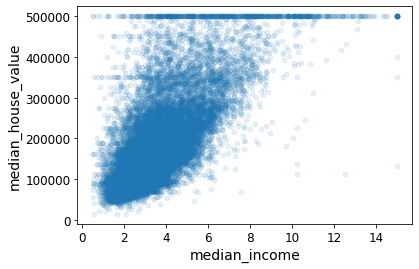

In [43]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

Les lignes horizontales du dernier graphique pourraient correspondre aux cases d'un questionnaire. Il serait légitime de supprimer les valeurs correspondantes si l'on voulait obtenir un résultat optimal.



#### Combinaison d'attributs

on va créer de nouvelles variables `rooms_per_household`, `bedrooms_per_room` et `population_per_household` et visualiser leur corrélation à `median_house_value`.

In [0]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5ba0e0d30>,
      dtype=object)

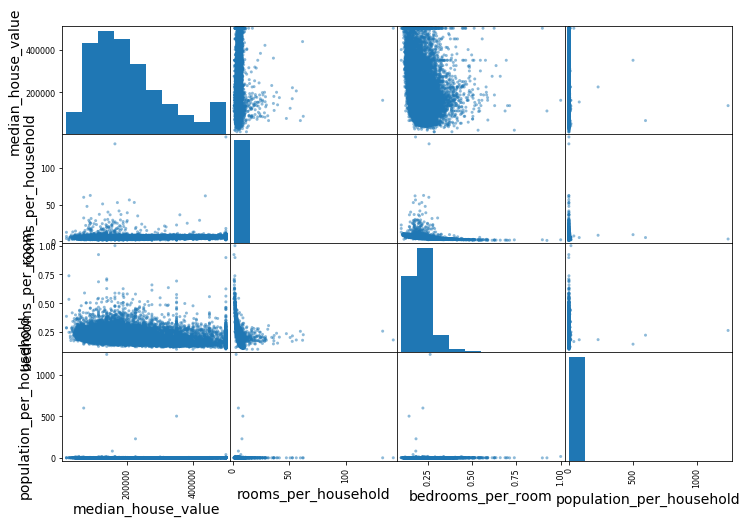

In [45]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "rooms_per_household", "bedrooms_per_room",
              "population_per_household"]
scatter_matrix(housing[attributes], figsize=(12, 8))

On obtient une corrélation négative assez prononcée avec `bedrooms_per_room`.
On va maintenant préparer les données pour l'apprentissage automatique.

## Préparation des données pour les algorithmes de ML

Il est indispensable de scripter cette préparation pour plusieurs raisons :
* Afin de la rendre reproductible, par exemple si on obtient une version plus récente du jeu initial.
* Afin de se constituer une bibliothèque d'utilitaires.
* Afin d'effectuer des bancs d'essai entre plusieurs stratégies de péparation.

On va commencer par scinder le jeu de données. D'une part, les variables-cibles, ou étiquettes, souvent notées $\Y$ (une seule ici donc $\y$) et de l'autre les autres variables notées $\X$. On obtiendra `housing_labels` et `housing`.

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Nettoyage des données


On a pu vu plus haut, en appelant la méthode `info()`, que la _feature_ `total_bedrooms` comptait des valeurs manquantes.

In [47]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


On teste ces options sur l'échantillon concerné `sample_incomplete_rows`.

In [48]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [49]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [50]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [51]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


`scikit-learn` propose une classe dédiée à ce genre de traitements : `SimpleImputer`.

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

on doit _dropper_ les autres variables pour le traitement car l'`imputer` ne s'applique qu'aux variables numériques.

In [0]:
#housing_num = housing.drop('ocean_proximity', axis=1)
# Plus général :
housing_num = housing.select_dtypes(include=[np.number]) 

On peut maintenant _entraîner_ l'`Imputer` avec la méthode `fit()`.

In [54]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

L'`Imputer` a calculé la médiane pour chaque variable et l'a stockée dans son attribut `statistics_`.

In [55]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [56]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

On peut alors transformer les données avec la méthode `transform()` de l'`Imputer` :

In [57]:
imputer.transform(housing_num)

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

Le résultat est un `array` `Numpy`. On va en refaire un `DataFrame` en récupérant les noms de colonnes dans `housing_num`.

In [58]:
pd.DataFrame(housing_num) 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


##### Attributs textuels et catégories

On s'intéresse maintenant aux variables catégorielles.



In [59]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Les algorithmes de _ML_ étant plus à l'aise avec des nombre, on _mappe_ ces catégories sur des nombres avec `OrdinalEncoder`. On utilise la méthode `fit_transform`.

In [60]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

L'`encoder` donne accès au mapping des catégories :

In [61]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### _One-hot encoding_

In [0]:
from sklearn.preprocessing import OneHotEncoder

On utilise la méthode `fit_transform` du `OneHotEncoder` qui retourne une `sparse matrix`, version compressée qu'on convertie avec la méthode `toarray()`.

In [63]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot 

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [64]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

On utilise l'option `sparse` de l'encodeur.

In [65]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot 

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

On a accès aux catégories _via_ l'attribut `categories_` de notre encodeur.

In [66]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### Transformations _ad hoc_

`scikit-learn` étant basé sur le _duck typing_, l'implémentation d'un transformer sera celle d'une classe comportant ces méthodes :
- `fit()` (retournant souvent `self`)
- `transform()`
- `fit_transform()` (obtenue gratuitement en ajoutant `TransformerMixin` aux classes de base)

L'ajout de la classe `BaseEstimator` aux classes de base permettra plus tard le tuning automatisé des _hyper-paramètres_. Elle a pour effet d'ajouter les méthodes `get_params` et `set_params` à condition d'avoir un nombre fixe de paramètres dans le constructeur (on évitera `*args` et `**kwargs`).

Le code ci-dessous nous sert à créer les variables combinées :

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# index pour chaque colonne
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

ici notre _transformer_ possède un  hyper-paramètre `add_bedrooms_per_room`. Il sera facile de modifier notre chaîne de traitement pour savoir si, oui ou non, ce paramètre doit être ajouté. Les paramètres permettent de retarder, voire d'automatiser, les prises de décision de ce genre.

In [0]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

In [69]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 2.7079646017699117,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 2.0259740259740258,
        0.24129098360655737],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 2.742483660130719,
        0.1796086508753862],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 3.808988764044944,
        0.19387755102040816],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.9859154929577465,
        0.22035541195476574]], dtype=object)

On reconstruit un dataframe 

In [70]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household", "bedrooms_per_room"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944,0.223852
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796,0.159057
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597,0.241291
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598,0.200866
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785,0.231341


##### _Feature scaling_

Les algos de ML ne marchent pas bien quand les _features_ ont des échelles très différentes (ex. `number_of_rooms` entre 0 et 40000 alors que `median_income` entre 0 et 15). Les stratégies pour y remédier sont : _min-max scaling_ et _standardization_.
Les algos de ML demande une normalisation et un standartisation des échelles :
* min-max scaling : _mappe_ min,max sur 0,1 (`MinMaxScaler`
* standardization : _mappe_ la moyenne sur zero avec variance unitaire. (`StandardScaler`)

En fonction des données du jeu d'entraînement (seulement) qu'on effectura les mises à l'échelle.

##### _Pipeline_ de transformation

Nous désirons pouvoir créer un _transformer_ qui serait la résultante de tous les autres .

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

 On aimerait va alimenter le _pipeline_ directement avec le `DataFrame` initial. On va utiliser `ColumnTransformer` pour créer l'embranchement.

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [74]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [75]:
housing_prepared.shape

(16512, 16)